# Projet numérique de Science des Données 2025

__Binôme numéro 29 -- BECK Corto et LELAIDIER Romain__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Un algorithme de prédiction du risque obstétrique, dans un contexte où les populations ont peu accès aux soins, pourrait vraiment jouer un rôle important. Il permettrait de détecter plus facilement les grossesses à risque, et donc d’orienter les efforts médicaux là où ils sont les plus nécessaires, surtout dans des régions où les ressources (et les médecins) sont rares. Si on met à disposition des outils simples permettant de mesurer les variables nécessaires (tension, glycémie...), les femmes pourraient faire un premier "auto-diagnostic" pour savoir s’il est urgent de consulter. Ça pourrait alléger le système de santé local et rendre l’accès aux soins un peu plus efficace, surtout si les consultations sont rares ou coûteuses.

Il faut toutefois faire attention aux dérives liées à son utilisation : chaque cas médical reste unique, et doit donc être traité et surveillé avec attention par un médecin qualifié.

En effet, l’utilisation uniquement d’un algorithme pour prédire le risque obstétrique présenterait des risques éthiques, notamment si l’algorithme est mal entraîné ou biaisé, ce qui peut entraîner de graves erreurs. Il ne doit pas remplacer un vrai diagnostic médical, mais rester un outil d’aide. Socialement, cela peut créer ou renforcer des inégalités, par exemple si certaines femmes sont poussées à avorter ou d’autres à être ignorées. Économiquement, remplacer des professionnels par des machines peut freiner les investissements en santé. Psychologiquement, le manque de contact humain peut être difficile à accepter. Enfin, la confidentialité des données est un enjeu important, surtout dans des régions sans protection légale.

Il ne s'agit pas de s'en remettre totalement à l'algorithme de classification, mais de l'utiliser comme outil pour appuyer des décisions.

</div>

## Librairies usuelles

In [2]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19)

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [3]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

In [4]:
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [4]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

In [6]:
X_train.shape, y_train.shape

((800, 6), (800,))

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

In [5]:
# couleurs pour l'indicateur de risque
import matplotlib.patches as mpatches

risk_colors = [
    'green',
    'yellow',
    'orange'
]


risk_labels = [
    'Faible', 
    'Moyen', 
    'Elevé'
]

risk_legend_patches = [ mpatches.Patch(color=risk_colors[i], label=risk_labels[i]) for i in range(3) ]

risk_cmap = matplotlib.colors.ListedColormap(risk_colors)

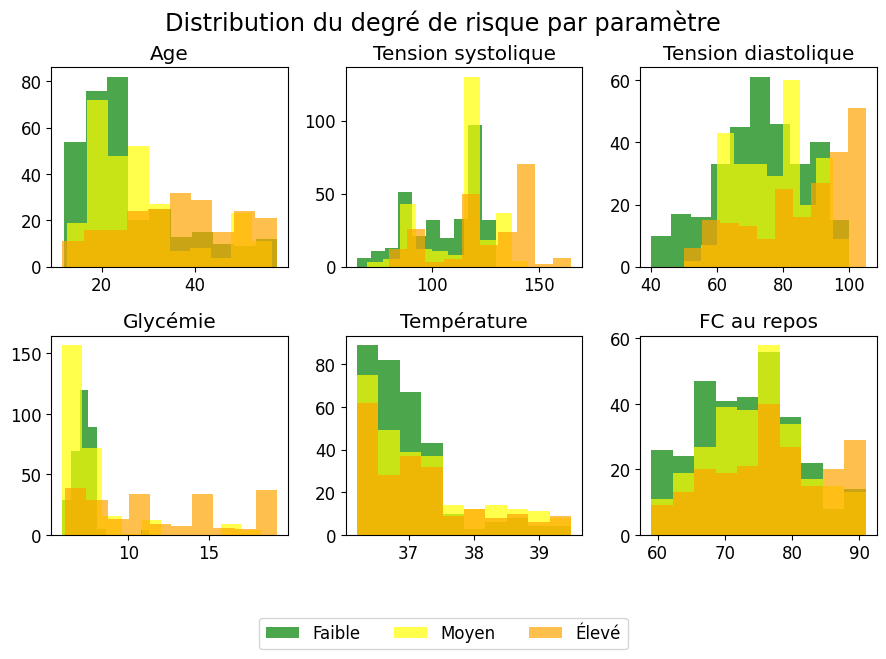

In [226]:
fig = plt.figure(figsize=(9, 6))

for (feat_idx, feat_name) in enumerate(df_train.columns[:6]):
    ax = fig.add_subplot(2, 3, (feat_idx+1))

    for risk_value in range(3):
        label = ['Faible', 'Moyen', 'Élevé'][risk_value] if feat_idx == 0 else None

        h = ax.hist(df_train[df_train['Risque'] == risk_value][feat_name],bins=10,edgecolor='none',alpha=0.7,color=risk_colors[risk_value],label=label)

    ax.set_title(feat_name)

fig.tight_layout(pad=1.0, rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribution du degré de risque par paramètre", fontsize="x-large")
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Les valeurs prises par les variables semblent cohérentes avec les indicateurs de "bonne santé" communément utilisés.

L’âge joue un rôle important. Les femmes très jeunes (moins de 25 ans) sont majoritairement dans la catégorie à faible risque, tandis que les risques moyens puis élevés apparaissent de plus en plus à partir de 30-35 ans. Cela correspond à l’idée que les complications augmentent avec l’âge.

Les tensions systolique et diastolique semblent également corrélées à un risque plus élevé : plus la catégorie de risque est élevée, plus les tensions mesurées sont importantes.

La température corporelle, en revanche, semble moins liée au risque de complications. Les différentes catégories de risque présentent des distributions de températures assez similaires.

Pour la fréquence cardiaque, on observe aussi une tendance à des valeurs plus élevées chez les patientes à risque, mais la différence est moins marquée que pour les tensions.

Chez les femmes qui présentent un risque élevé, on retrouve une glycémie souvent beaucoup plus importante que la moyenne, tandis que la majorité des femmes des catégories "moyen" et "faible" présentent une glycémie plus faible comprise entre 5 mmol/L et 10 mmol/L.

Cela dit, pour chaque variable qui semble corrélée au risque, on peut toujours trouver des cas particuliers qui vont à l'encontre de cette corrélation. C’est la combinaison de plusieurs indicateurs qui permet d’évaluer le risque, et non une seule variable prise isolément.

</div>

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Prédire le risque de grossesse à risque à partir de ces six variables semble plutôt difficile, aucune variable ne montrant à elle seule une différence vraiment nette entre les risques faible, moyen et fort. Cependant, en combinant ces variables avec des coefficients adaptés, il est possible d’obtenir une prédiction correcte.

Certaines variables paraissent plus importantes visuellement pour estimer le risque, notamment le taux de glycémie, l’âge et les tensions artérielles. Même si on ne peut pas espérer une classification parfaite, les données d’entraînement restent prometteuses.

</div>

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [6]:
from sklearn import preprocessing, decomposition

In [91]:
def center_reduce(X):
    std_scale = preprocessing.StandardScaler().fit(X)
    return std_scale.transform(X)

In [92]:
# centrage et réduction des composantes de X_train
X_scaled = center_reduce(X_train)

# initialisation de l'APC pour 2 dimensions
pca = decomposition.PCA(n_components=2)

# calcul de l'APC
pca.fit(X_scaled)

# reprojection des données
X_projected = pca.transform(X_scaled)

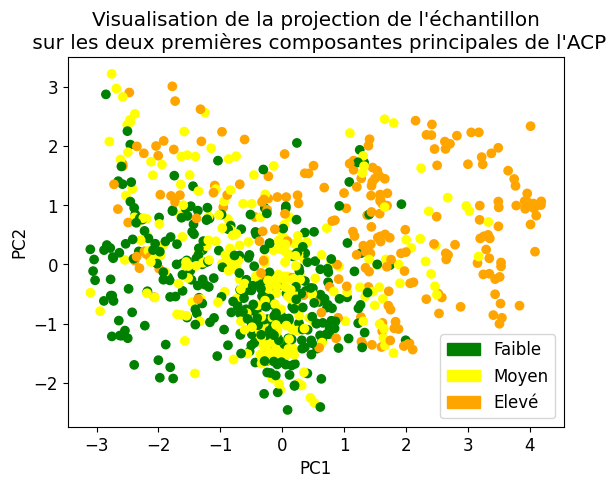

In [93]:
# affichage
plt.scatter(X_projected[:,0], X_projected[:,1], c=df_train['Risque'], cmap=risk_cmap)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=risk_legend_patches)
plt.title("Visualisation de la projection de l'échantillon\n sur les deux premières composantes principales de l'ACP")
plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Cette ACP nous permet de distinguer des tendances pouvant être utiles afin de prédire le risque de grossesse difficile.

Globalement, le risque est plus élevé pour des composantes principales PC1 et PC2 plus élevées.

Cependant, la composante PC2 semble moins pertinente que la PC1 pour distinguer les niveaux de risques puisqu'on observe par exemple plusieurs occurences de risques faibles et moyens pour une composante PC2 élevée. Mais cela était attendu puisque la deuxième directions principale présente une variance plus faible que la première.

De plus, les risques faibles et moyens présentent des distributions assez similaires et il semble difficile de les distinguer grâce à cette ACP uniquement.

Afin d'y voire plus clair, nous pouvons nous intéresser à la proportion de variance expliquée par ces deux composantes :

</div>

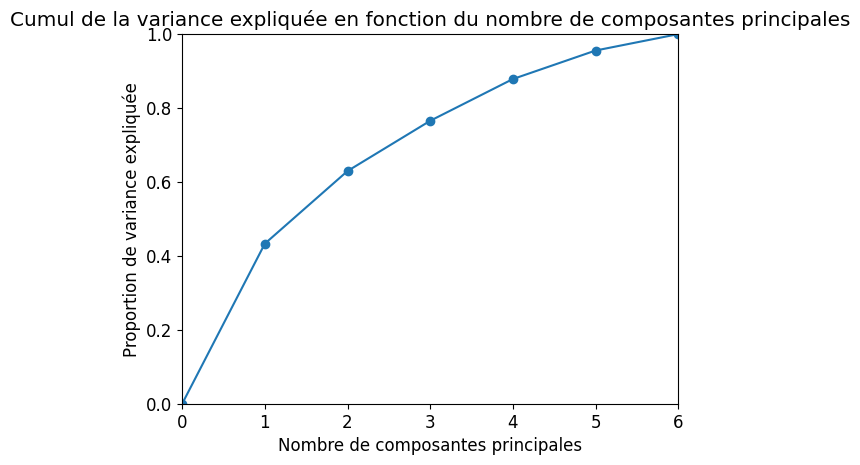

In [46]:
pca2 = decomposition.PCA(n_components=6)
pca2.fit(X_scaled)

x_vals = np.arange(0, 7)
y_vals = np.insert(pca2.explained_variance_ratio_.cumsum(), 0, 0)

plt.plot(x_vals, y_vals, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.title("Cumul de la variance expliquée en fonction du nombre de composantes principales")
plt.ylim(0, 1)
plt.xlim(0, 6)
plt.show()

In [47]:
decomposition.PCA().fit(X_scaled).explained_variance_ratio_

array([0.43311432, 0.19646383, 0.1359057 , 0.1129674 , 0.07713432,
       0.04441443])

Les deux premières composantes principales ne permettent donc d'expliquer qu'environ 63% de la variance totale et il faut considérer au moins 5 composantes afin d'atteindre les 95%. Il est donc préférable de ne pas se limiter qu'aux deux premières composantes principales.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

In [48]:
import seaborn as sns

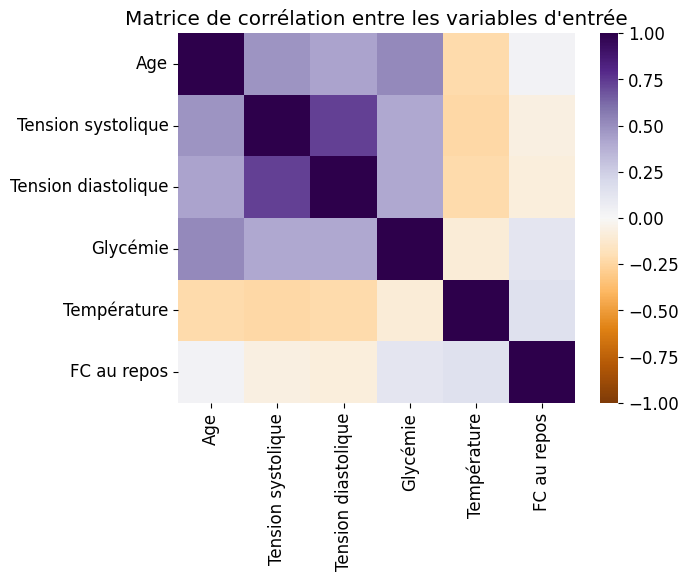

[[ 1.00125156  0.48326422  0.42952259  0.52378213 -0.2192495   0.0347252 ]
 [ 0.48326422  1.00125156  0.72961185  0.4126828  -0.23963067 -0.06487187]
 [ 0.42952259  0.72961185  1.00125156  0.41048993 -0.22509561 -0.08544316]
 [ 0.52378213  0.4126828   0.41048993  1.00125156 -0.0958218   0.1219226 ]
 [-0.2192495  -0.23963067 -0.22509561 -0.0958218   1.00125156  0.15533372]
 [ 0.0347252  -0.06487187 -0.08544316  0.1219226   0.15533372  1.00125156]]


In [49]:
corr_matrix = df_train.drop(columns=['Risque']).corr()

sns.heatmap(
    corr_matrix,
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap = 'PuOr',
)

plt.title("Matrice de corrélation entre les variables d'entrée")
plt.show()

print(np.cov(X_scaled.T))

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

La matrice de corrélation permet d'identifier quelles variables sont corrélées entre elles et donc porteuses de la même information. 

Ici, la tension diastolique et la tension systolique sont assez fortement linéairement et positivement corrélées puisque leur coefficient de Pearson vaut environ 0,73 (il s'agit du plus élévé). On  peut donc écarter une des deux variables afin de réduire la dimension des données sans perdre trop d'information.

</div>

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [51]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

L'accuracy vaut en général :

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

Pour le modèle considéré, on a :

$$ \text{Accuracy} = \frac{N_{\text{majoritaire}}}{N} $$

où $n$ est le nombre total d'observations et $n_{\text{majoritaire}}$ est le nombre d'observations de la classe majoritaire.

</div>

In [52]:
TP = max(np.sum(y_train_risk_vs_norisk == 0), np.sum(y_train_risk_vs_norisk == 1))
accuracy = TP / len(y_train_risk_vs_norisk)
print(f"L'accuracy vaut {accuracy}")

L'accuracy vaut 0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

La précision équilibrée est une moyenne entre le rappel et la spécificité, 'est-à-dire entre le taux de vrais négatifs et le taux de vrais positifs. 

Ce critère est donc préférableà l'accuracy car on veut que le modèle reconnaisse bien à la fois les cas à risque et ceux qui ne le sont pas, pas seulement une seule catégorie.

Par exemple, un modèle qui prédit toujours la même classe (comme dans la question précédente) aura une précision équilibrée de 0,5, quel que soit le déséquilibre dans les données. Même si 90 % des patients sont à risque, et que l’accuracy serait alors très élevée (90 %), ce modèle reste mauvais pour détecter les 10 % restants. En revanche, le balanced accuracy resterait à 0,5, ce qui reflète mieux cette limite.

Ainsi, dès que la précision équilibrée est supérieure à 0,5, cela signifie que le modèle sait un minimum bien distinguer les deux classes.

</div>

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

La phase d'entraînement consiste simplement à mémoriser (stocker) les données d'entraînement et leurs étiquettes. Aucun calcul n'est effectué à ce stade. La classification d'une nouvelle observation se fait ensuite en trouvant le point d'entraînement le plus proche.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Comme l'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche et que le voisin le plus proche d'un point du jeu d'entrainement est lui-même, on s'attend à obtenir une précision équilibrée de 1.

Il peut y avoir une exception si il y a des doublons étiquetés différemment, mais cela est peu probable dans notre situation et la précision resterait proche de 1.

</div>

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score

In [59]:
neighbors_classifier = KNeighborsClassifier(n_neighbors = 1)
neighbors_classifier.fit(X_scaled, y_train_risk_vs_norisk)

y_train_risk_vs_norisk_predKPP1 = neighbors_classifier.predict(X_scaled)

ba_train = balanced_accuracy_score(y_train_risk_vs_norisk, y_train_risk_vs_norisk_predKPP1)

print(f"La précision équilibrée vaut {ba_train:.3f}")

La précision équilibrée vaut 1.000


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

L'algorithme du plus proche voisins étant basé sur les distances euclidiennes entre les points, les variables avec un plus grand ordre de grandeur et une plus grande variance vont avoir une plus grande influence sur les résultats. En centrant et réduisant les données , on donne un poids équitable à chaque variable, ce qui améliore la performance du modèle.

</div>

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [54]:
print(f"Taille de l'échantillon : {X_scaled.shape[0]}")

Taille de l'échantillon : 800


<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Le choix des valeurs possibles de $K$ dépend de la taille de l'échantillon dont nous disposons. Si on prend $K$ trop proche de cette taille, l'algorithme KPP perd l'information "locale" des points, parce qu'il renvoie le mode de l'échantillon. Si on prend $K$ trop petit, l'algorithme fait une forme de surapprentissage, puisqu'il "n'étale pas l'information".

Pour illustrer cela, nous avons testé une grille pour $K$ allant de $1$ à $720$ (la grille est dégressive, au sens où la densité de valeurs testées diminue pour les grandes valeurs de $K$). L'échantillon étant de taille $800$, un jeu d'entraînement dans un des $10$ folds est de taille $800-80=720$. $K=720$ est donc la valeur maximale possible.

</div>

In [11]:
from sklearn import model_selection 
from sklearn.neighbors import KNeighborsClassifier

In [60]:
# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Grille pour k
ks = np.floor(np.logspace(0, np.log10(720), 100)).astype(np.int64)

# Modèle à évaluer
neighbors_classifier = KNeighborsClassifier()

# Recherche sur grille : instantiation
grid_KPP = model_selection.GridSearchCV(
    neighbors_classifier,
    {'n_neighbors': ks},
    cv=kf, # on utilise les folds déjà définis
    scoring='balanced_accuracy'
)

# Recherche sur grille : apprentissage
grid_KPP.fit(X_scaled, y_train_risk_vs_norisk)

# Optimum
print(f"Le nombre optimal de plus proches voisins est {grid_KPP.best_params_['n_neighbors']}, pour une précision équilibrée de {grid_KPP.best_score_}.")

Le nombre optimal de plus proches voisins est 12, pour une précision équilibrée de 0.7525033702321438.


In [61]:
def display_grid_optim_graph(grid, param, param_values, param_name, title):
    scores_mean = grid.cv_results_['mean_test_score']
    scores_std = grid.cv_results_['std_test_score']

    plt.figure(figsize=(8, 4))

    # Moyenne et écart-type
    plt.plot(
        grid.cv_results_['param_' + param],
        scores_mean, 
        label="Précision équilibrée", color='tab:blue'
    )
    plt.plot(
        grid.cv_results_['param_' + param],
        scores_mean + scores_std, 
        color='tab:blue', linestyle='dashed',
        label="écart-type"
    )
    plt.plot(
        grid.cv_results_['param_' + param],
        scores_mean - scores_std, 
        color='tab:blue', linestyle='dashed'
    )

    # Colorisation
    plt.fill_between(
        param_values,
        scores_mean + scores_std,
        scores_mean - scores_std, 
        color='tab:blue',
        alpha=0.2, # contrôle la transparence
    )

    # Meilleur score
    plt.scatter(
        grid.best_params_[param],
        grid.best_score_, 
        color='tab:red',
        label='Précision équilibrée optimale'
    )

    # Mise en forme
    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel("Précision équilibrée")
    plt.xlim([param_values[0], param_values[-1]])
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

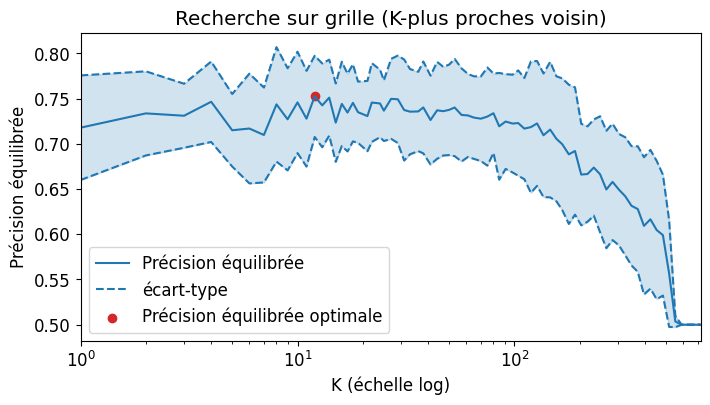

In [62]:
display_grid_optim_graph(grid_KPP, "n_neighbors", ks, "K (échelle log)", "Recherche sur grille (K-plus proches voisin)")

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Avec $K=1$, le classifieur renvoie la classe du point d'entraînement le plus proche. La précision équilibrée est réduite à cause du surapprentissage, car le classifieur a une approche très locale.

Avec $K>50$, l'approche beaucoup plus globale. Le classifieur sous-apprend et sa réponse moyenne se rapproche du mode de l'échantillon. C'est ce qui se passe dès que $K$ est proche de $720$ : quel que soit le vecteur d'entrée, le classifieur renvoie toujours la même réponse, qui est la valeur la plus fréquente dans l'échantillon d'entraînement.

L'optimum est ici $K=12$, pour une précision équilibrée de $75\%$.

</div>

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [63]:
print(f"Nombre de paramètres : {X_scaled.shape[1]}")

Nombre de paramètres : 6


<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Les données d'entraînement présentent 6 paramètres, donc le paramètre de régression $\beta$ évolue dans $\R^7$. C'est un ensemble de dimension relativement petite, donc pour ne prendre aucun risque d'éliminer des variables déterminantes dans la classification, on choisit une régularisation $\cal{l}^2$.

Si la dimension de cet espace avait été beaucoup plus grande, on aurait pu préférer une régularisation $\cal{l}^1$, qui a tendance à annuler les coordonnées de $\beta$, afin de supprimer les variables non discriminantes (ou "inutiles").

</div>

In [18]:
from sklearn.linear_model import LogisticRegression

In [64]:
# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Grille pour C : de 1e-4 à 1e2
Cs = np.logspace(-4, 2, 100)

# Modèle à évaluer
logistic_regression_classifier = LogisticRegression(
    penalty='l2', # solver='liblinear'
)

# Recherche sur grille : instantiation
grid_LR = model_selection.GridSearchCV(
    logistic_regression_classifier,
    {'C': Cs},
    cv=kf, # on utilise les folds déjà définis
    scoring='balanced_accuracy'
)

# Recherche sur grille : apprentissage
grid_LR.fit(X_scaled, y_train_risk_vs_norisk)

# Optimum
print(f"Le régulariseur optimal est C={grid_LR.best_params_['C']}, pour une précision équilibrée de {grid_LR.best_score_}.")

Le régulariseur optimal est C=0.7564633275546291, pour une précision équilibrée de 0.6654428031786523.


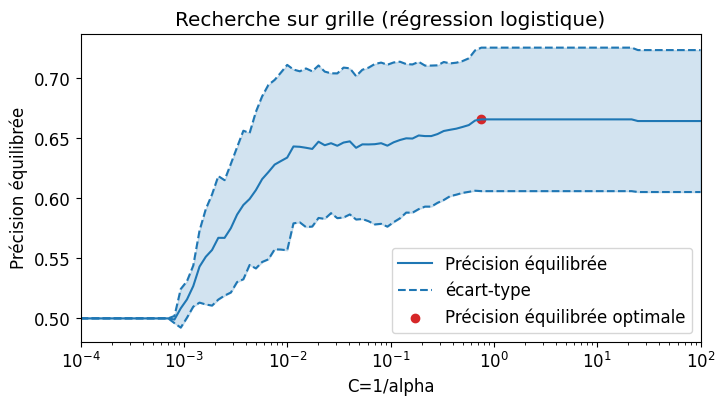

In [65]:
display_grid_optim_graph(grid_LR, "C", Cs, "C=1/alpha", "Recherche sur grille (régression logistique)")

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

La régularisation vise à empêcher le surapprentissage du modèle. Dans le cas d'une régularisation logistique $\cal{l}^2$, on pénalise les grandes valeurs de $||\beta||^2$.

Les valeurs de $C$ basses ($C<10^{-1}$) correspondent à un $\alpha$ élevé, donc la norme de $\beta$ est prépondérante dans la fonction de coût, et le modèle sous-apprend. C'est pourquoi la précision équilibrée est basse.

Les valeurs de $C$ élevées devraient, à l'inverse, conduire le modèle à surapprendre. Ainsi, lors de l'évaluation du modèle par les données de test dans un fold, on s'attend à ce que la précision équilibrée soit également basse, et qu'il y ait en fait une valeur de $C$ optimale entre les deux, qui donne la meilleure précision équilibrée.

Or ici, ce n'est pas le cas : la précision équilibrée n'est pas en cloche, mais semble croître avec $C$. Cela montre que le modèle de régression logistique n'est pas adapté à ce problème : ou bien le modèle sousapprend, ou bien il n'apprend pas. Il n'y a pas de paramètre $C$ optimal pour classifier les données.

**Remarque.** Selon le solver utilisé, la courbe de précision équilibrée varie beaucoup. Par exemple, avec le solver `biblinear`, on observe une cloche, mais le sousapprentissage est peu marqué.

</div>

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Utiliser un perceptron multi-couches pour un jeu à 6 paramètres ne semble pas efficace, car le modèle va très rapidement sur-apprendre.

Compte-tenu de la visualisation effectuée en question 5, il semble plus pertinent d'utiliser la méthode SVC plutôt qu'une méthode utilisant des arbres de décision. En effet, cette visualisation semble dégager des "zones" délimitant les individus à risque de ceux qui ne le sont pas. Ces zones ne semblent pas délimitées par un quadrillage, mais plutôt par des formes vagues, ce qui encourage plutôt l'utilisation d'une machine à vecteur de support à noyau.

Nous jouons à nouveau, dans cette question, avec le paramètre de régularisation $\alpha=1/C$. Le même argument que la question précédente justifie le choix de la régularisation $\cal l^2$.

</div>

In [23]:
from sklearn.svm import SVC

In [66]:
# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Grille pour C : de 1e-2 à 1e2
Cs = np.logspace(-2, 2, 20)

# Modèle à évaluer
SVC_classifier = SVC()

# Recherche sur grille : instantiation
grid_SVC = model_selection.GridSearchCV(
    SVC_classifier,
    {'C': Cs},
    cv=kf, # on utilise les folds déjà définis
    scoring='balanced_accuracy'
)

# Recherche sur grille : apprentissage
grid_SVC.fit(X_scaled, y_train_risk_vs_norisk)

# Optimum
print(f"Le régulariseur optimal est {grid_SVC.best_params_['C']}, pour une précision équilibrée de {grid_SVC.best_score_}.")

Le régulariseur optimal est 3.359818286283781, pour une précision équilibrée de 0.7519466848664963.


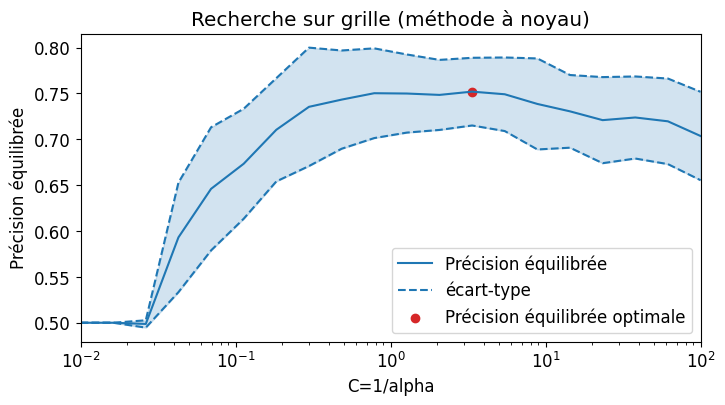

In [67]:
display_grid_optim_graph(grid_SVC, "C", Cs, "C=1/alpha", "Recherche sur grille (méthode à noyau)")

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Avec ce modèle, nous observons clairement une précision équilibrée en cloche. Cela montre que le modèle est adapté à la structure des tests que nous étudions. Les valeurs de $C$ basses engendrent du sous-apprentissage, celles élevées (à droite) créent du surapprentissage, qui dégrade la qualité du modèle.

Au milieu, une valeur de $C$ optimale, $3.36$, donne une précision équilibrée de $75\%$, soit le même résultat qu'avec les K-plus proches voisins.

</div>

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

La meilleure performance a été obtenue avec la méthode à noyau.

</div>

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

In [110]:
def reduction_dimension(variance_expliquee_min):
    pca3 = decomposition.PCA(n_components=6)
    pca3.fit(X_scaled)

    # calcul du nombre de composantes nécessaires pour expliquer au moins cette variance
    variance_cumulee = np.insert(pca3.explained_variance_ratio_.cumsum(), 0, 0)
    n_components = min(variance_cumulee.searchsorted(variance_expliquee_min, 'right'), 6)
    print(f"Nombre de composantes : {n_components}, expliquant {variance_cumulee[n_components]*100}% de variance")

    # initialisation de l'APC pour n_components dimensions
    pca3 = decomposition.PCA(n_components)
    # calcul de l'APC
    pca3.fit(X_scaled)

    # fonction de transformation des données d'entrées avant la prédiction
    # de sorte que les données test subissent les mêmes transformations que les
    # données d'entraînement
    def reducer(X):
        # reprojection des données
        X_apc = pca3.transform(X)
        return X_apc
    
    return reducer(X_scaled), n_components, reducer

In [115]:
X_reduced_scaled, n_components, reducer = reduction_dimension(0.7)

Nombre de composantes : 3, expliquant 76.54838500485046% de variance


### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

In [116]:
# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Grille pour C : de 1e-2 à 1e2
Cs = np.logspace(-2, 2, 20)

# Modèle à évaluer
SVC_classifier = SVC()

# Recherche sur grille : instantiation
grid_SVC = model_selection.GridSearchCV(
    SVC_classifier,
    {'C': Cs},
    cv=kf, # on utilise les folds déjà définis
    scoring='balanced_accuracy'
)

# Recherche sur grille : apprentissage
grid_SVC.fit(X_reduced_scaled, y_train_risk_vs_norisk)

# Optimum
print(f"Le régulariseur optimal est {grid_SVC.best_params_['C']}, pour une précision équilibrée de {grid_SVC.best_score_}.")

Le régulariseur optimal est 3.359818286283781, pour une précision équilibrée de 0.7097589433627169.


<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Avec une variance expliquée de $1$ en entrée, on trouve les mêmes valeurs de sortie pour $C$ et pour la précision équilibrée qu'en question 17, ce qui montre la correction du pré-traitement en question 19.

</div>

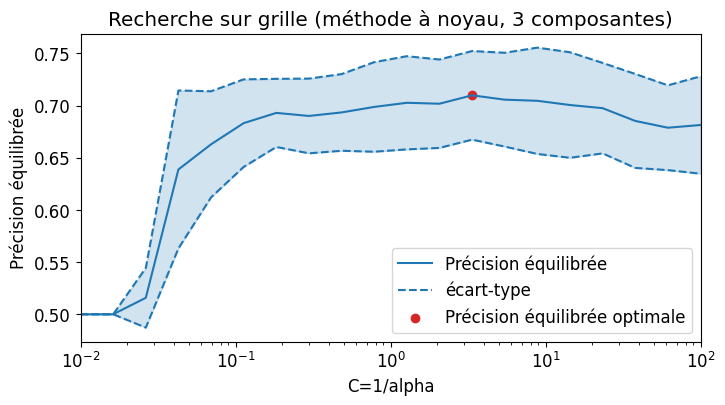

In [117]:
display_grid_optim_graph(grid_SVC, "C", Cs, "C=1/alpha", f"Recherche sur grille (méthode à noyau, {n_components} composantes)")

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

La réduction de dimension, avec 77% de variance expliquée, a conduit à une diminution de la précision équilibrée du modèle, qui a perdu 5 points (de 75% à 70%). C'est plutôt un bon résultat, étant donné que l'on a réduit de 23 points la variance expliquée du modèle. Bien que l'erreur moyenne du classifieur soit légèrement plus élevée, on a pu diviser par deux la dimension du problème, pour obtenir des résultats quasi-similaires.

La réduction de dimension peut donc s'avérer utile dans les cas où la dimension d'entrée est très élevée, afin d'accélérer la vitesse d'entraînement du modèle, sans perdre beaucoup en exactitude.

</div>

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Nous choisissons pour la suite un classifieur de type méthode à noyau, avec une réduction de dimension expliquant 80% de la variance du jeu d'entraînement.

</div>

In [118]:
def get_final_binary_classifier(variance_expliquee_min):
    X_final, n_components_final, reducer = reduction_dimension(variance_expliquee_min)

    # Création des folds
    kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

    # Grille pour C : de 1e-2 à 1e2
    Cs = np.logspace(-2, 2, 20)

    # Modèle à évaluer
    SVC_classifier = SVC()

    # Recherche sur grille : instantiation
    grid_SVC = model_selection.GridSearchCV(
        SVC_classifier,
        {'C': Cs},
        cv=kf, # on utilise les folds déjà définis
        scoring='balanced_accuracy'
    )

    # Recherche sur grille : apprentissage
    grid_SVC.fit(X_final, y_train_risk_vs_norisk)

    # Optimum
    print(f"Le régulariseur optimal est {grid_SVC.best_params_['C']}, pour une précision équilibrée de {grid_SVC.best_score_}.")

    return SVC(C=grid_SVC.best_params_['C']).fit(X_final, y_train_risk_vs_norisk), reducer

In [119]:
final_binary_classifier, reducer = get_final_binary_classifier(0.7)

Nombre de composantes : 3, expliquant 76.54838500485046% de variance
Le régulariseur optimal est 3.359818286283781, pour une précision équilibrée de 0.7097589433627169.


### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [104]:
df_test = pd.read_csv('data/donnees_reservees.csv')
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int')

# centrage et réduction
X_test_scaled = center_reduce(X_test)

# combinaison des étiquettes 1 et 2
df_test_risk_vs_norisk = df_test.copy()
df_test_risk_vs_norisk['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])
y_test_risk_vs_norisk = np.array(df_test_risk_vs_norisk['Risque'], dtype='int')

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [121]:
X_test_reduced = reducer(X_test_scaled)
y_test_pred = final_binary_classifier.predict(X_test_reduced)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [122]:
ba_test = balanced_accuracy_score(y_test_risk_vs_norisk, y_test_pred)

print(f"La précision équilibrée vaut {ba_test:.3f}")

La précision équilibrée vaut 0.770


<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Notre classifieur final obtient, sur le jeu de test, une précision équilibrée de 77%, ce qui est encore mieux que la moyenne obtenue sur la grille.

</div>

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

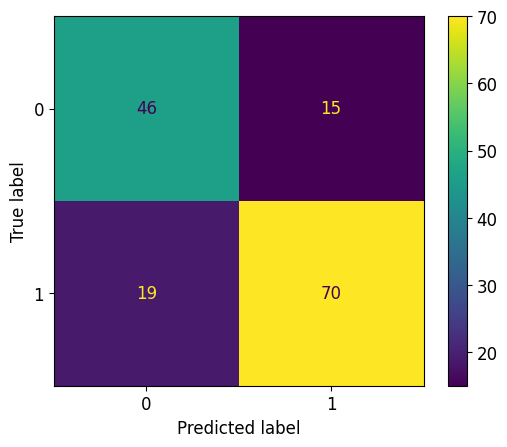

In [129]:
cm = confusion_matrix(y_test_risk_vs_norisk, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

Bien que la précision équilibrée soit élevée (77%), la matrice de confusion montre qu'il sera difficile pour l'hôpital de prendre une décision à partir de ce test. En effet, le taux de faux positifs est presque aussi élevé que le taux de faux négatifs. L'hôpital risque donc de traiter plus de patientes que nécessaire.

</div>

Nombre de composantes : 6, expliquant 100.0% de variance
Le régulariseur optimal est 3.359818286283781, pour une précision équilibrée de 0.7519466848664963.
La précision équilibrée vaut 0.869


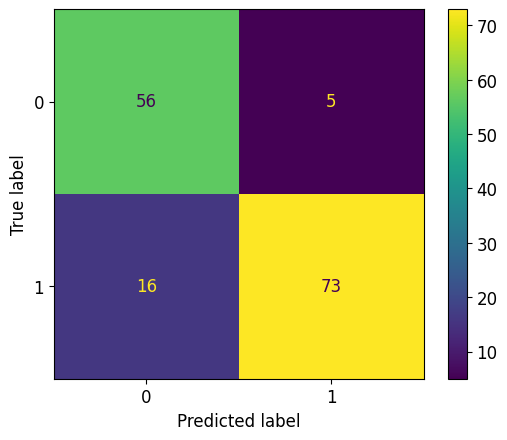

In [132]:
final_binary_classifier, reducer = get_final_binary_classifier(1)
ba_test = balanced_accuracy_score(y_test_risk_vs_norisk, y_test_pred)
print(f"La précision équilibrée vaut {ba_test:.3f}")
cm = confusion_matrix(y_test_risk_vs_norisk, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

<div style="background:#0f02;width:calc(100% - 2em);padding:1em;border-radius:0.4em">

En conservant 100% de la variance, la précision équilibrée augmente largement (+10 points). Mais surtout, la matrice de confusion change de forme : la quantité de faux positif a été divisée par 3. C'est un bon point pour l'hôpital, qui peut maintenant faire confiance au modèle lorsque celui-ci classe une patiente "à risque".

Ainsi, l'hôpital peut rediriger les patientes déclarées "sans risque" vers des tests médicaux moins coûteux afin d'éliminer tout doute. Par rapport au modèle précédent (77% de variance expliquée), le gain est que l'hôpital va enclencher moins de procédures de traitement coûteuses, pour des patientes qui n'en avaient en fait pas besoin.

Pour résumer :
- à 77% de variance expliquée, le test n'est pas concluant, le doute subsiste dans tous les cas pour l'hôpital, qui doit traiter tous les cas "à risque" avec des procédures coûteuses, et tous les cas "sans risque" avec des examens médicaux complémentaires moins coûteux.
- à 100% de variance expliquée, moins de patientes seront déclarées "à risque", mais dans ce cas le modèle est fiable, car il y a très peu de faux positifs. L'hôpital peut donc concentrer plus de moyens pour moins de patientes, et rediriger toutes les autres vers les examens complémentaires, nécessaires dans tous les cas.

</div>

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.